# EDA of GDELT news collected

In this notebook I will perform a simple EDA on a (representative) subset of the news collected. The intention is to define a cleaning process for later creating a cleaner script that will be used to clean all the data collected.

In that way, the cleaned data will be used as input for a text-summarization ML model.

Firts imports and define necessary functions to load the content from S3 bucket

In [28]:
import pandas as pd
import boto3
import random
from io import StringIO

#Initialize the S3 client
s3_client = boto3.client('s3')

def list_csv_files(bucket_name):
    response = s3_client.list_objects_v2(Bucket=bucket_name)
    csv_files = [obj['Key'] for obj in response.get('Contents', []) if obj['Key'].endswith('.csv')]
    return csv_files

def select_random_files(file_list, n):
    return random.sample(file_list, n)

def load_csv_from_s3(bucket_name, file_key):
    response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    csv_content = response['Body'].read().decode('utf-8')
    return pd.read_csv(StringIO(csv_content))

def load_random_csvs(bucket_name, file_list, n):
    selected_files = select_random_files(file_list, n)
    dataframes = [load_csv_from_s3(bucket_name, file) for file in selected_files]
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df

In [29]:
#List the number of files in the bucket where the news were collected
bucket_name = 'rcg-news-gdelt'
csv_files = list_csv_files(bucket_name)
print(f"Found {len(csv_files)} CSV files in the bucket.")

Found 241 CSV files in the bucket.


In [30]:
#Get a random subset of those files
n = 100
combined_df = load_random_csvs(bucket_name, csv_files, n)
combined_df = combined_df.dropna()
combined_df = combined_df.drop_duplicates(subset="body")
print(f"Loaded {len(combined_df)} rows from {n} CSV files.")

Loaded 13671 rows from 100 CSV files.


In [31]:
combined_df.isna().sum()

url      0
title    0
body     0
dtype: int64

In [32]:
#Add a column containing the length of the bodies
combined_df["body_len"] = combined_df["body"].apply(len)
combined_df.head(8)

,url,title,body,body_len
1,https://www.rte.ie/news/ukraine/2024/0101/1424...,Russia suffering major losses in Ukraine - Zel...,Ukrainian President Volodymyr Zelensky has sai...,4387
2,https://www.lbc.co.uk/news/small-boat-crossing...,Small boat crossings fall by a third as govern...,LBC. Ali Miraj12pm - 3pm. News. Ali Miraj is L...,3368
3,https://www.themalaysianinsight.com/s/478666,Israel army warns Gaza war will continue throu...,Updated 6 months ago ·\n Published ...,6286
4,https://www.nydailynews.com/2024/01/01/n-y-law...,N.Y. lawmakers headed back to Albany for start...,Daily News e-Edition. Evening e-Edition. Sign ...,2023
5,https://www.bangkokpost.com/thailand/general/2...,"Bangkok Post - Leaders offer New Year wishes,...",PUBLISHED : 2 Jan 2024 at 06:19. NEWSPAPER SEC...,2592
6,https://www.bostonherald.com/2024/01/01/migran...,Migrant buses bypass NYC for New Jersey,E-Edition. Sign up for email newsletters. . Si...,3970
7,https://nypost.com/2024/01/01/opinion/why-eric...,Why Eric Adams' 'tough' moves on migrants keep...,Thanks for contacting us. We've received your ...,2026
8,https://news.yahoo.com/virginia-man-hit-killed...,"Virginia man hit, killed by car on I-270 in Mo...","MONTGOMERY COUNTY, Md. (DC News Now) — Marylan...",3019


The first thing to do is to see the distribution of the length of the body of the articles

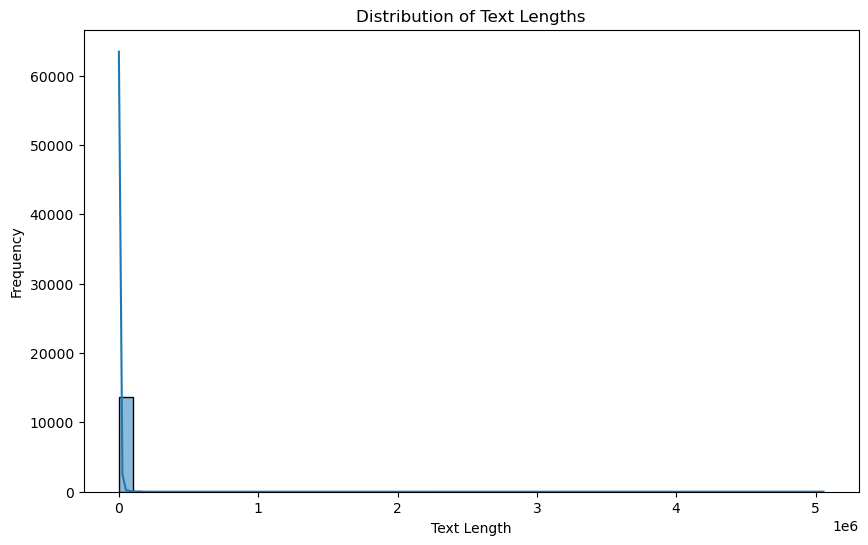

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plot the distribution for
def visualize_text_length_distribution(df, length_column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[length_column], bins=50, kde=True)
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()
    
visualize_text_length_distribution(combined_df, "body_len")

The graph is telling us that probably there is a few text that are extremely large compare to the rest. Let's see the distribution. First get a few statistics of the lengths

In [34]:
combined_df[["body_len"]].describe().T

,count,mean,std,min,25%,50%,75%,max
body_len,13671.0,5668.742082,47122.166154,5.0,2037.5,3303.0,5299.0,5056258.0


Clearly there are a few text which are very large, as the 75% of them are less than 5253 characters long, but there is a maximum of more that 500.000 words. Let's see the distributions

In [35]:
def calculate_length_ranges(df, length_column, bins):
    """
    Calculate the percentage of texts that fall within different length ranges.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    length_column (str): The name of the column containing the text lengths.
    bins (list): The list of bin edges for calculating the length ranges.
    
    Returns:
    pd.Series: The percentages of texts in each length range.
    """
    length_ranges = pd.cut(df[length_column], bins=bins)
    length_range_counts = length_ranges.value_counts(normalize=True) * 100
    return length_range_counts

bins = [0, 100, 500, 1000, 5000, 10000, 15000, float('inf')]

length_range_percentages = calculate_length_ranges(combined_df, "body_len", bins)

In [36]:
length_range_percentages

body_len
(1000.0, 5000.0]      64.640480
(5000.0, 10000.0]     20.539829
(500.0, 1000.0]        5.105698
(10000.0, 15000.0]     3.920708
(15000.0, inf]         3.116085
(100.0, 500.0]         2.289518
(0.0, 100.0]           0.387682
Name: proportion, dtype: float64

As the majority of them (around 90%) fall into the 500 to 10000 range, we will set those as the boundaries, and filter the rest by eliminating them

In [37]:
def filter_texts_by_length(df, length_column, min_length, max_length):
    filtered_df = df[(df[length_column] >= min_length) & (df[length_column] <= max_length)]
    return filtered_df

filtered_df = filter_texts_by_length(combined_df, "body_len", 500, 10000)
filtered_df.shape

(12344, 4)

Now, let's see the length distribution of this new filtered DF

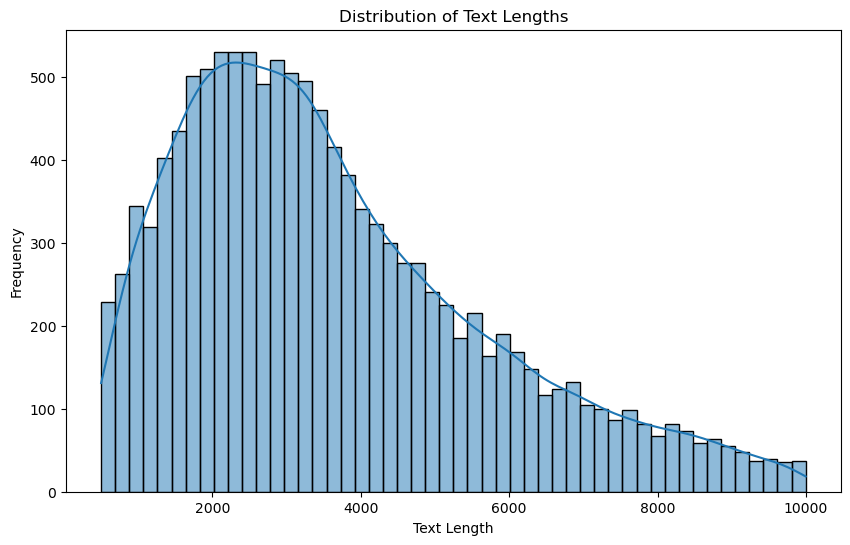

In [38]:
visualize_text_length_distribution(filtered_df, "body_len")

This is a much more clear diagram of the distribution. We can see that the distribution is skewed to the left, meaning that is much more common to find news shorter than longer. That should be taken into account for selecting the text-summarization model for tagging the data.

Next step is to focus on the content itself ot the texts. First of all, cleaning all the "strange" characters (non-printeable) or excesive whitespaces. Also, clean all symbols that are not letters, numbers or common punctuation symbols.

In [39]:
import re

def clean_text(text):
    #Remove non-printable characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    #Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    #Remove special symbols (keeping regular punctuation)
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\!\?\;\:\'\"]+', '', text)
    
    #Remove double .. that may have been generated because of the way the lambda function is defined
    text = text.replace("..", ".")
    
    return text

#Apply to the body of the DF
filtered_df["body"] = filtered_df["body"].apply(clean_text)
#Update the length column
filtered_df["body_len"] = filtered_df["body"].apply(len)
filtered_df.head(8)

/tmp/ipykernel_415/290922494.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["body"] = filtered_df["body"].apply(clean_text)
/tmp/ipykernel_415/290922494.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["body_len"] = filtered_df["body"].apply(len)


,url,title,body,body_len
1,https://www.rte.ie/news/ukraine/2024/0101/1424...,Russia suffering major losses in Ukraine - Zel...,Ukrainian President Volodymyr Zelensky has sai...,4352
2,https://www.lbc.co.uk/news/small-boat-crossing...,Small boat crossings fall by a third as govern...,LBC. Ali Miraj12pm 3pm. News. Ali Miraj is Le...,3345
3,https://www.themalaysianinsight.com/s/478666,Israel army warns Gaza war will continue throu...,Updated 6 months ago Published on 2 Jan 2024 7...,6175
4,https://www.nydailynews.com/2024/01/01/n-y-law...,N.Y. lawmakers headed back to Albany for start...,Daily News eEdition. Evening eEdition. Sign up...,2003
5,https://www.bangkokpost.com/thailand/general/2...,"Bangkok Post - Leaders offer New Year wishes,...",PUBLISHED : 2 Jan 2024 at 06:19. NEWSPAPER SEC...,2574
6,https://www.bostonherald.com/2024/01/01/migran...,Migrant buses bypass NYC for New Jersey,EEdition. Sign up for email newsletters. . Sig...,3942
7,https://nypost.com/2024/01/01/opinion/why-eric...,Why Eric Adams' 'tough' moves on migrants keep...,Thanks for contacting us. We've received your ...,1983
8,https://news.yahoo.com/virginia-man-hit-killed...,"Virginia man hit, killed by car on I-270 in Mo...","MONTGOMERY COUNTY, Md. DC News Now Maryland St...",2973


The final step would be to eliminate all the sentences which are advertise or promotional content. This can be done using the nltk library, splitting the bodies into sentences and keeping only the onews that do not include promotional content.

In [40]:
import nltk

nltk.download('punkt')

def remove_promotional_content(text):
    
    #Define common promotional phrases
    promo_phrases = [
        "GO AD FREE", "Get your Digital Subscription", "Use code", "More on", "News you can trust",
        "day forecast", "Home", "Article", "click here", "buy now", "limited time offer", "subscribe now",
        "unlock the no-ads mode", "go premium", "ad-free", "Free trial", "Sign up now", "Limited time offer",
        "Act now", "Don't miss out", "Buy one get one free", "Special discount", "Hurry up", "Order now",
        "Money back guarantee", "Exclusive offer", "Best deal", "Save now", "Get started", "Shop now",
        "Learn more", "Subscribe today", "Best price", "Offer ends soon", "Download now", "Call now",
        "Visit our website", "Premium access", "Instant access", "Join now", "Unlock access", "VIP access",
        "Discount code", "Promo code", "Register now", "Claim your free gift", "Satisfaction guaranteed",
        "Follow us", "Connect with us", "Like and share", "Follow for updates", "Upgrade now", "Become a member",
        "Sign in to access", "For more information", "Read more", "Click to continue", "Watch now", "Find out more",
        "Discover more", "Start your journey", "Enhance your experience", "Get the best", "Reserve your spot",
        "Act fast", "Check this out", "Try it free", "Explore now", "Book your place", "Request a quote",
        "Limited stock", "On sale now", "Contact us today", "Free shipping", "Subscribe for updates",
        "Click to learn more", "Experience the best", "Shop the collection", "Buy now pay later", "Email newsletter"
        "Limited time only", "Get yours today"
    ]
    
    #Split the text into sentences (punctuation is preserved)
    sentences = nltk.sent_tokenize(text)

    #Remove sentences containing promotional phrases
    cleaned_sentences = [sentence for sentence in sentences if not any(promo.lower() in sentence.lower() for promo in promo_phrases)]

    #Join the cleaned sentences back into a single text
    cleaned_text = ' '.join(cleaned_sentences)
    
    return cleaned_text

#Apply the function to the body of the DF
filtered_df["body"] = filtered_df["body"].apply(remove_promotional_content)
#Update the length column
filtered_df["body_len"] = filtered_df["body"].apply(len)

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/tmp/ipykernel_415/1631781671.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["body"] = filtered_df["body"].apply(remove_promotional_content)
/tmp/ipykernel_415/1631781671.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["body_len"] = filtered_df["body"].apply(len)


Now visualize the length distribution again to see how it is now after all the changes applied.

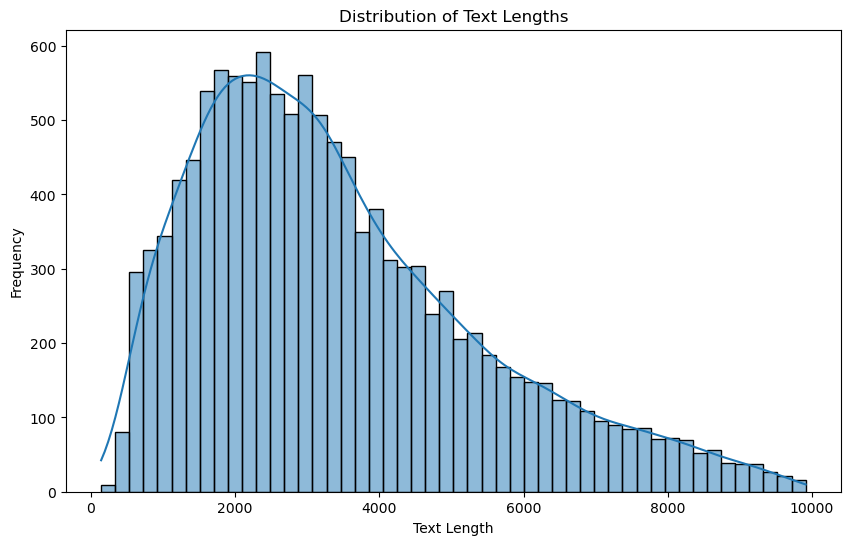

In [41]:
visualize_text_length_distribution(filtered_df, "body_len")

Some news may have become too short, or were purely promotional content from the start. So finally let's filter all bodies that have been left with a body shorter that 450 characters.

In [44]:
filtered_df = filtered_df[filtered_df["body_len"] > 450]
filtered_df.head()

,url,title,body,body_len
1,https://www.rte.ie/news/ukraine/2024/0101/1424...,Russia suffering major losses in Ukraine - Zel...,Ukrainian President Volodymyr Zelensky has sai...,4352
2,https://www.lbc.co.uk/news/small-boat-crossing...,Small boat crossings fall by a third as govern...,LBC. Ali Miraj12pm 3pm. News. Ali Miraj is Le...,2981
3,https://www.themalaysianinsight.com/s/478666,Israel army warns Gaza war will continue throu...,Updated 6 months ago Published on 2 Jan 2024 7...,5998
4,https://www.nydailynews.com/2024/01/01/n-y-law...,N.Y. lawmakers headed back to Albany for start...,Daily News eEdition. Evening eEdition. Sign up...,2003
5,https://www.bangkokpost.com/thailand/general/2...,"Bangkok Post - Leaders offer New Year wishes,...",PUBLISHED : 2 Jan 2024 at 06:19. NEWSPAPER SEC...,2574


This notebook has set all necessary steps to create the cleaning script that later will be developed.